<a href="https://colab.research.google.com/github/YC0429/Time_Series_Proj/blob/main/Time_Series_workplace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1st Part: Climate Change and CO2 levels prediction
 Atmospheric CO2 from Continuous Air Samples at Mauna Loa Observatory, Hawaii, U.S.A.

 https://gml.noaa.gov/ccgg/trends/index.html

## Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
# Importing libraries
from pandas import read_csv
from statsmodels.tsa.stattools import adfuller
import os
import warnings
# warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from pylab import rcParams

import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_error

from plotly import tools

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#https://drive.google.com/file/d/1JJB4SO5XCq_B3TVbYe57c4RDQ6-xV074

link = 'https://drive.google.com/open?id=1JJB4SO5XCq_B3TVbYe57c4RDQ6-xV074'

## Read in the data

In [4]:
# Extract file ID from the link
fluff, id = link.split('=')
# Create a Google Drive file instance
file = drive.CreateFile({'id':id})
# Print file metadata
print(file)
# Download the file from Google drive
file.GetContentFile('co2.csv')
# Read the CSV file into a pandas DataFrame，parse the specified column as datetime objects，sets the specified column as the index of the DataFrame
Co2_df  = pd.read_csv('co2.csv', parse_dates=['date'], index_col='date')
Co2_df.head()

GoogleDriveFile({'id': '1JJB4SO5XCq_B3TVbYe57c4RDQ6-xV074'})


,co2
date,
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [5]:
Co2_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2284 entries, 1958-03-29 to 2001-12-29
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   co2     2225 non-null   float64
dtypes: float64(1)
memory usage: 35.7 KB


## EDA below

missing data volume:  co2    59
dtype: int64


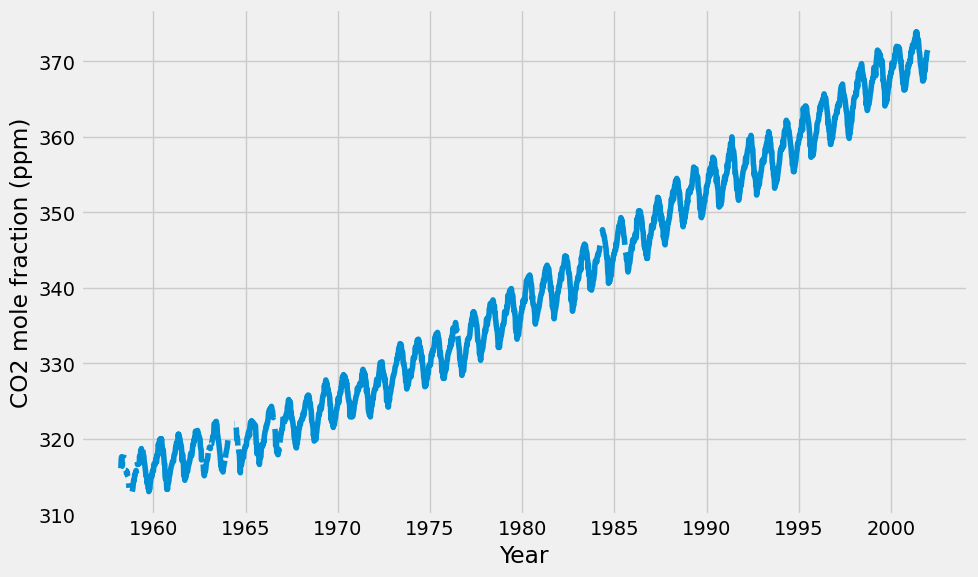

In [6]:
# Plot below to check weekly distribution of co2 mole fraction
plt.figure(figsize=(10, 6))
plt.xlabel('Year')
plt.ylabel('CO2 mole fraction (ppm)')
plt.plot(Co2_df)
print("missing data volume: ", Co2_df.isnull().sum())
plt.tight_layout()

In [7]:
# Resample the 'co2' data to monthly frequency and compute the mean for each month
monthly = Co2_df['co2'].resample('MS').mean()
monthly.isnull().sum()

5

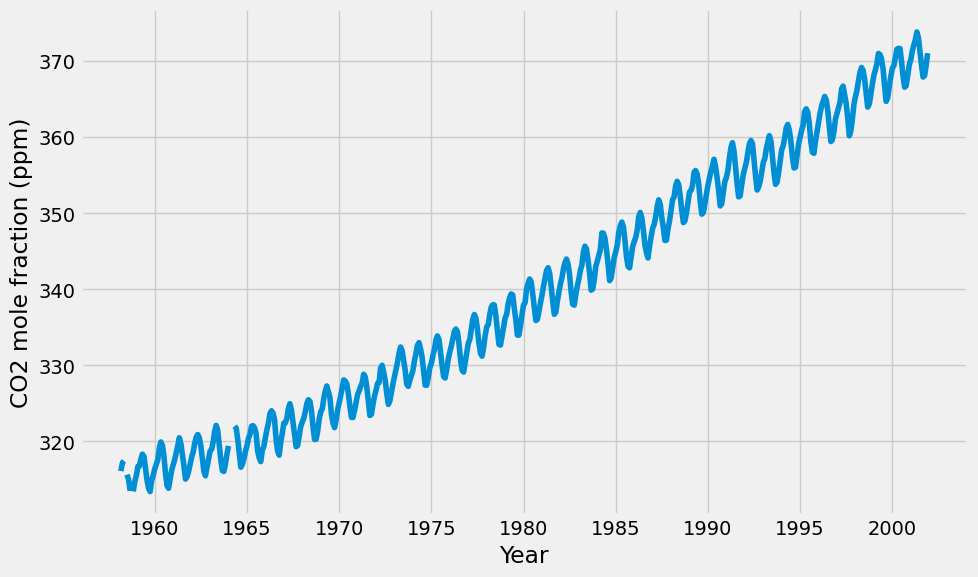

In [8]:
# Plot below to check monthly distribution of co2 mole fraction
plt.figure(figsize=(10, 6))
plt.xlabel('Year')
plt.ylabel('CO2 mole fraction (ppm)')
plt.plot(monthly)
plt.tight_layout()

In [9]:
monthly.head()

date
1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01           NaN
1958-07-01    315.625000
Freq: MS, Name: co2, dtype: float64

In [10]:
monthly.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 526 entries, 1958-03-01 to 2001-12-01
Freq: MS
Series name: co2
Non-Null Count  Dtype  
--------------  -----  
521 non-null    float64
dtypes: float64(1)
memory usage: 8.2 KB


In [11]:
monthly.describe()

count    521.000000
mean     339.822665
std       17.068711
min      313.400000
25%      324.125000
50%      337.950000
75%      354.675000
max      373.800000
Name: co2, dtype: float64

### Fill in the NaN value using backfill

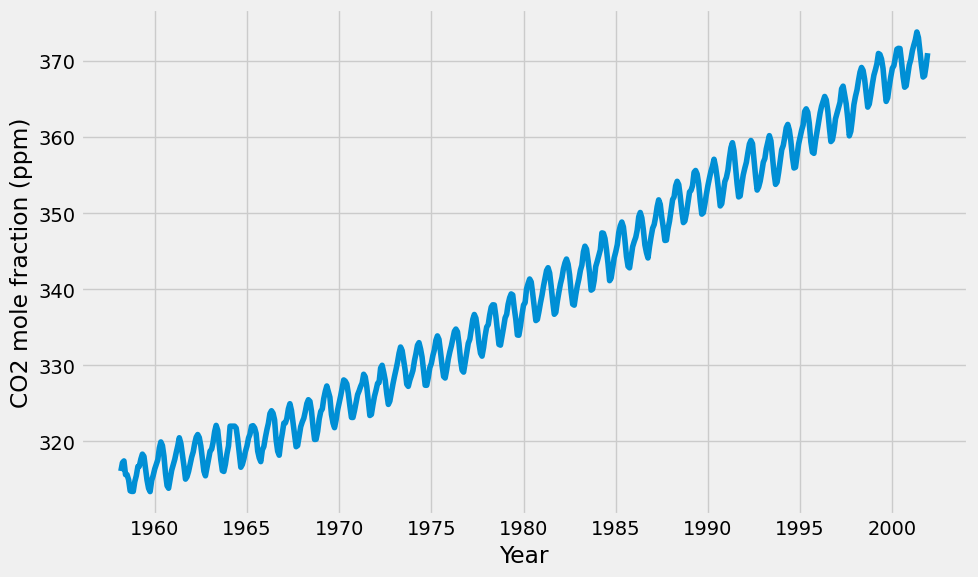

In [12]:
# Fill NaNs using backward fill
monthly = monthly.fillna(monthly.bfill())

plt.figure(figsize=(10, 6))
plt.xlabel('Year')
plt.ylabel('CO2 mole fraction (ppm)')
plt.plot(monthly)
plt.tight_layout()

### Visualize rolling mean and rolling standard deviation below

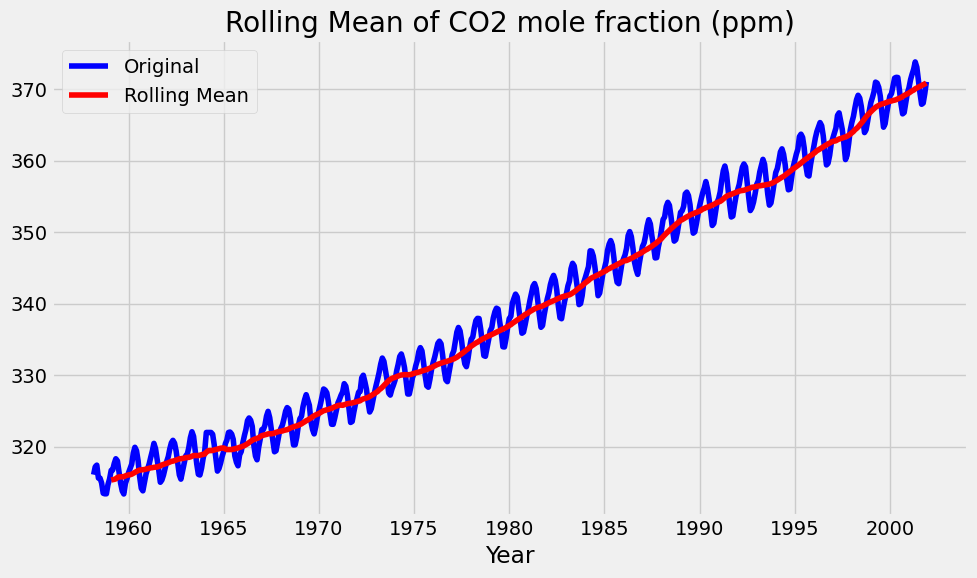

In [13]:
# Calculate rolling mean and rolling standard deviation, the size of the window is 12 data point, which will make it to be a 12 month window here
rollingmean = monthly.rolling(window=12).mean()
rollingstd = monthly.rolling(window=12).std()
plt.figure(figsize=(10, 6))
orig = plt.plot(monthly, color='blue', label='Original')
mean = plt.plot(rollingmean, color='red', label='Rolling Mean')
# std = plt.plot(rollingstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.xlabel('Year')
plt.title('Rolling Mean of CO2 mole fraction (ppm)')
plt.tight_layout()
plt.show(block=False)

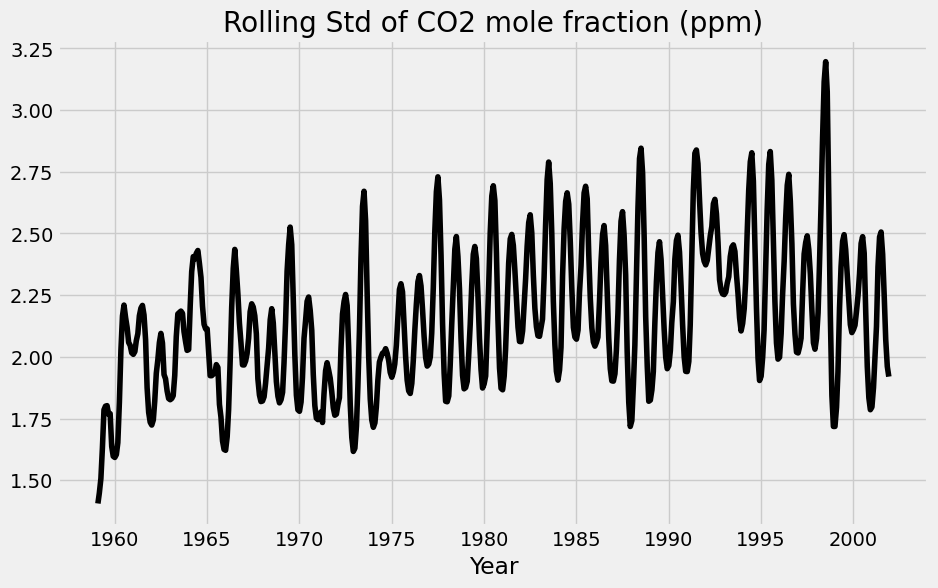

<Figure size 640x480 with 0 Axes>

In [14]:
plt.figure(figsize=(10, 6))
std = plt.plot(rollingstd, color='black', label='Rolling Std')
plt.xlabel('Year')
plt.title('Rolling Std of CO2 mole fraction (ppm)')
plt.show(block=False)
plt.tight_layout()
plt.show(block=False)

## Decompose the time series data and visualize each component below

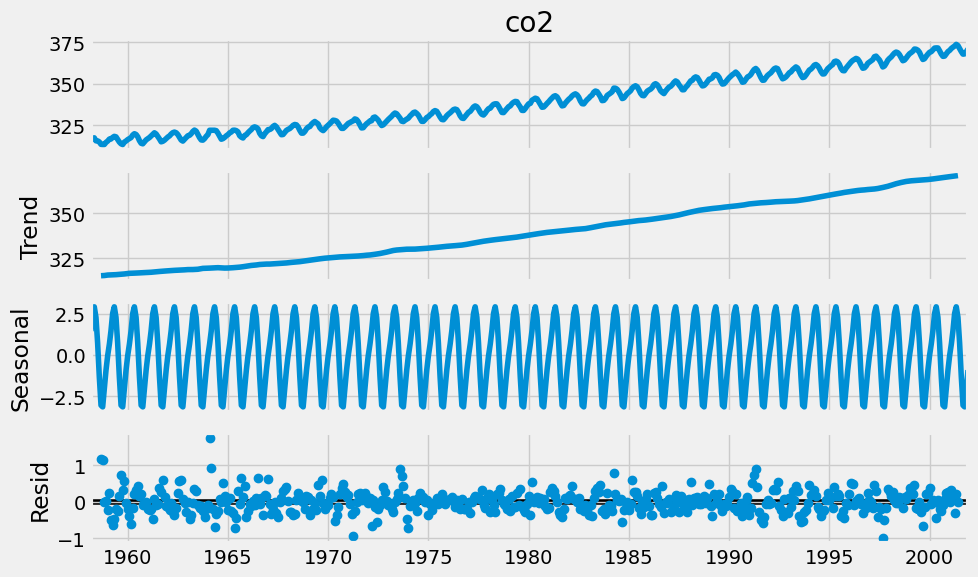

In [15]:
deco = sm.tsa.seasonal_decompose(monthly, model='additive')
fig = deco.plot()
fig.set_size_inches(10, 6)
fig.tight_layout()
plt.show()

In [16]:
# Check the residual stats
deco.resid.describe()

count    514.000000
mean       0.002790
std        0.298683
min       -0.997063
25%       -0.195065
50%       -0.008551
75%        0.166299
max        1.745334
Name: resid, dtype: float64

In [17]:
deco.resid.isnull().sum()

12

### Fill in NaNs for Residual using backfill and visualize residual

In [18]:
CO2Residual = deco.resid
CO2Residual = CO2Residual.fillna(CO2Residual.bfill())
CO2Residual = CO2Residual.fillna(CO2Residual.ffill())

In [19]:
CO2Residual.describe()

count    526.000000
mean       0.016137
std        0.320423
min       -0.997063
25%       -0.192372
50%       -0.000486
75%        0.169395
max        1.745334
Name: resid, dtype: float64

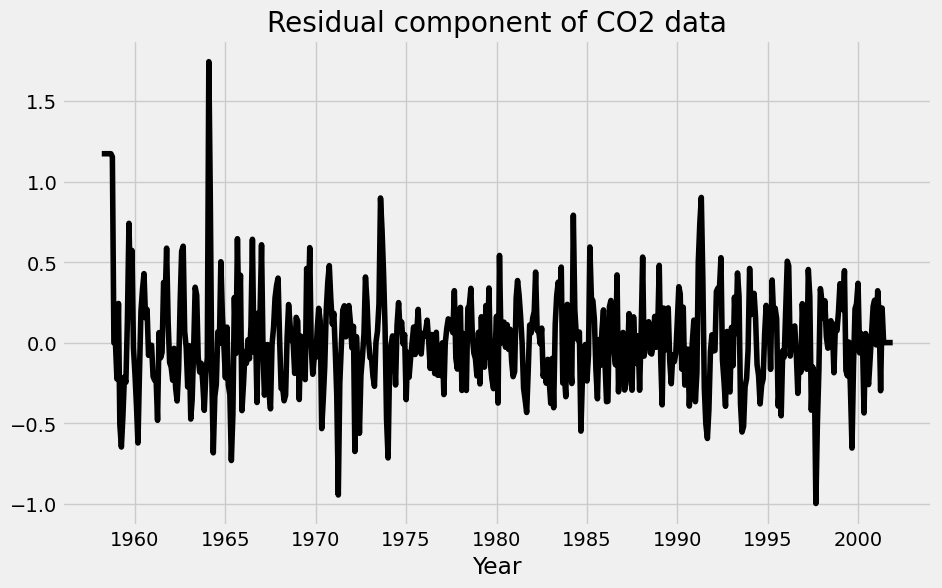

<Figure size 640x480 with 0 Axes>

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(CO2Residual, color='black')
plt.xlabel('Year')
plt.title('Residual component of CO2 data')
plt.show(block=False)
plt.tight_layout()
plt.show(block=False)

### Use ADF test to check whether Residual data is stationary

In [21]:
ADFresult = adfuller(CO2Residual)

In [22]:
ADFresult

(-12.181866290608015,
 1.345823691226738e-22,
 9,
 516,
 {'1%': -3.443086684769254,
  '5%': -2.867157550015396,
  '10%': -2.5697619453458325},
 5.109878354831608)

In [23]:
print('ADF Statistic: %f' % ADFresult[0])
print('p-value: %f' % ADFresult[1])
print('Critical Values:')
for key, value in ADFresult[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -12.181866
p-value: 0.000000
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


### Fill in NaN for trend component and visualize trend

In [24]:
CO2trend = deco.trend
CO2trend = CO2trend.fillna(CO2trend.bfill())
CO2trend = CO2trend.fillna(CO2trend.ffill())
print(CO2trend.isnull().sum())
CO2trend

0


date
1958-03-01    315.375000
1958-04-01    315.375000
1958-05-01    315.375000
1958-06-01    315.375000
1958-07-01    315.375000
                 ...    
2001-08-01    370.787917
2001-09-01    370.787917
2001-10-01    370.787917
2001-11-01    370.787917
2001-12-01    370.787917
Freq: MS, Name: trend, Length: 526, dtype: float64

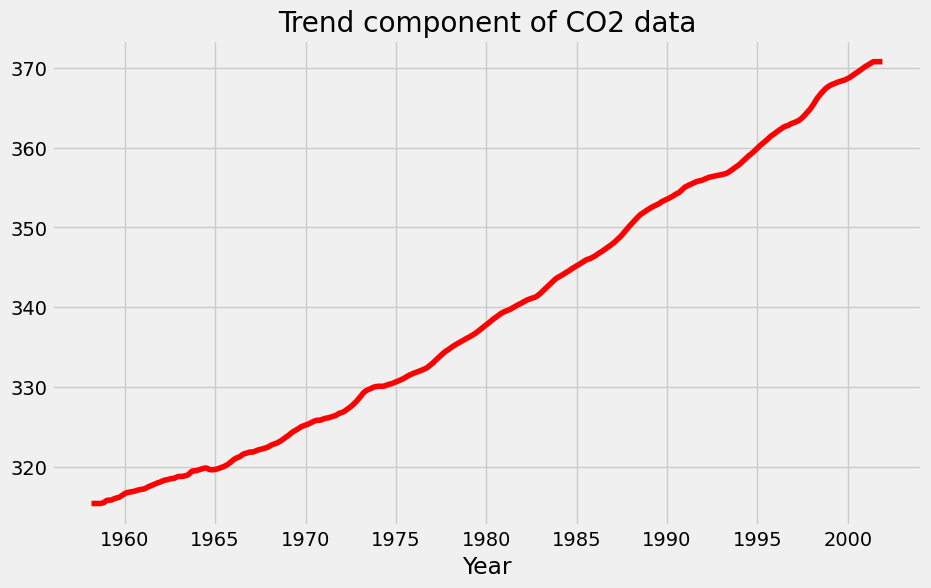

<Figure size 640x480 with 0 Axes>

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(CO2trend , color='red', label='CO2trend')
plt.xlabel('Year')
plt.title('Trend component of CO2 data')
plt.show(block=False)
plt.tight_layout()
plt.show(block=False)

### Use ADF test to check whether Trend data is stationary

In [26]:
ADFresult = adfuller(CO2trend)

In [27]:
print('ADF Statistic: %f' % ADFresult[0])
print('p-value: %f' % ADFresult[1])
print('Critical Values:')
for key, value in ADFresult[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: 1.761347
p-value: 0.998269
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


## Check ACF and PACF plot for monthly aggregated data

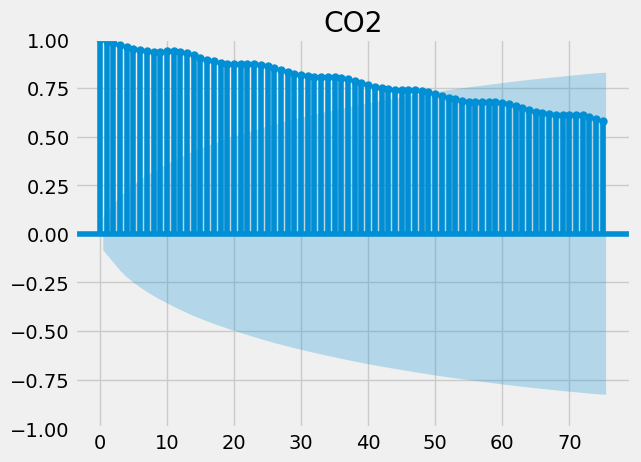

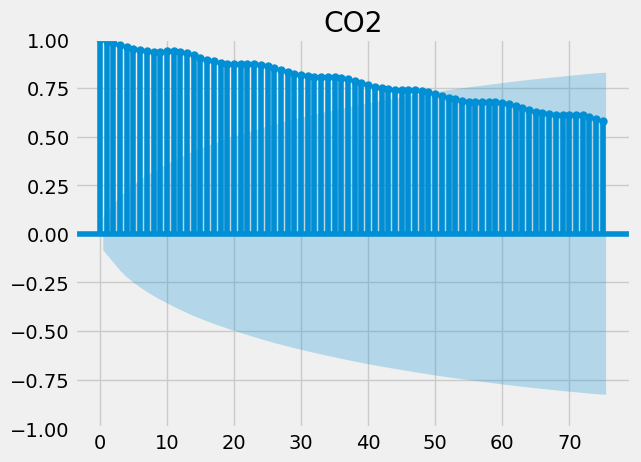

In [28]:
# Plot ACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#plot_acf(CO2Residual,title="CO2")
plot_acf(monthly,lags=75,title="CO2")

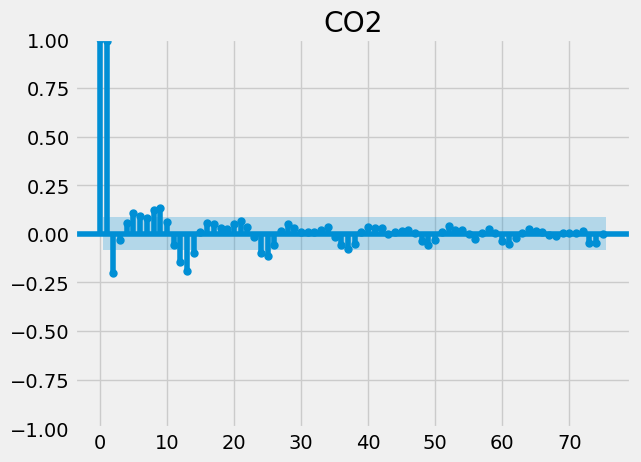

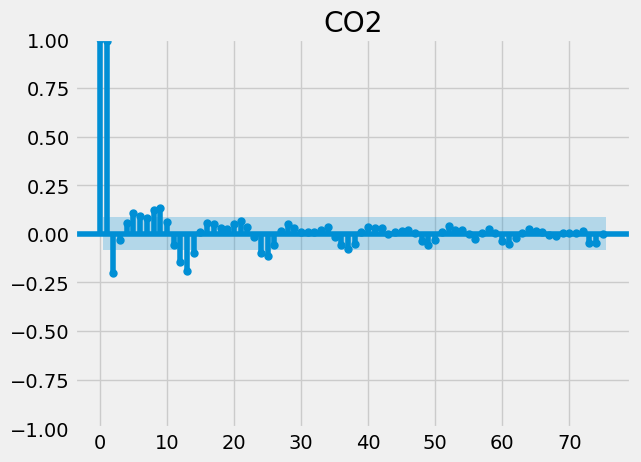

In [29]:
# Plot PACF
#plot_pacf(CO2Residual,title="CO2")
plot_pacf(monthly,lags=75,title="CO2")

## SARIMAX model with d,p,q = 1

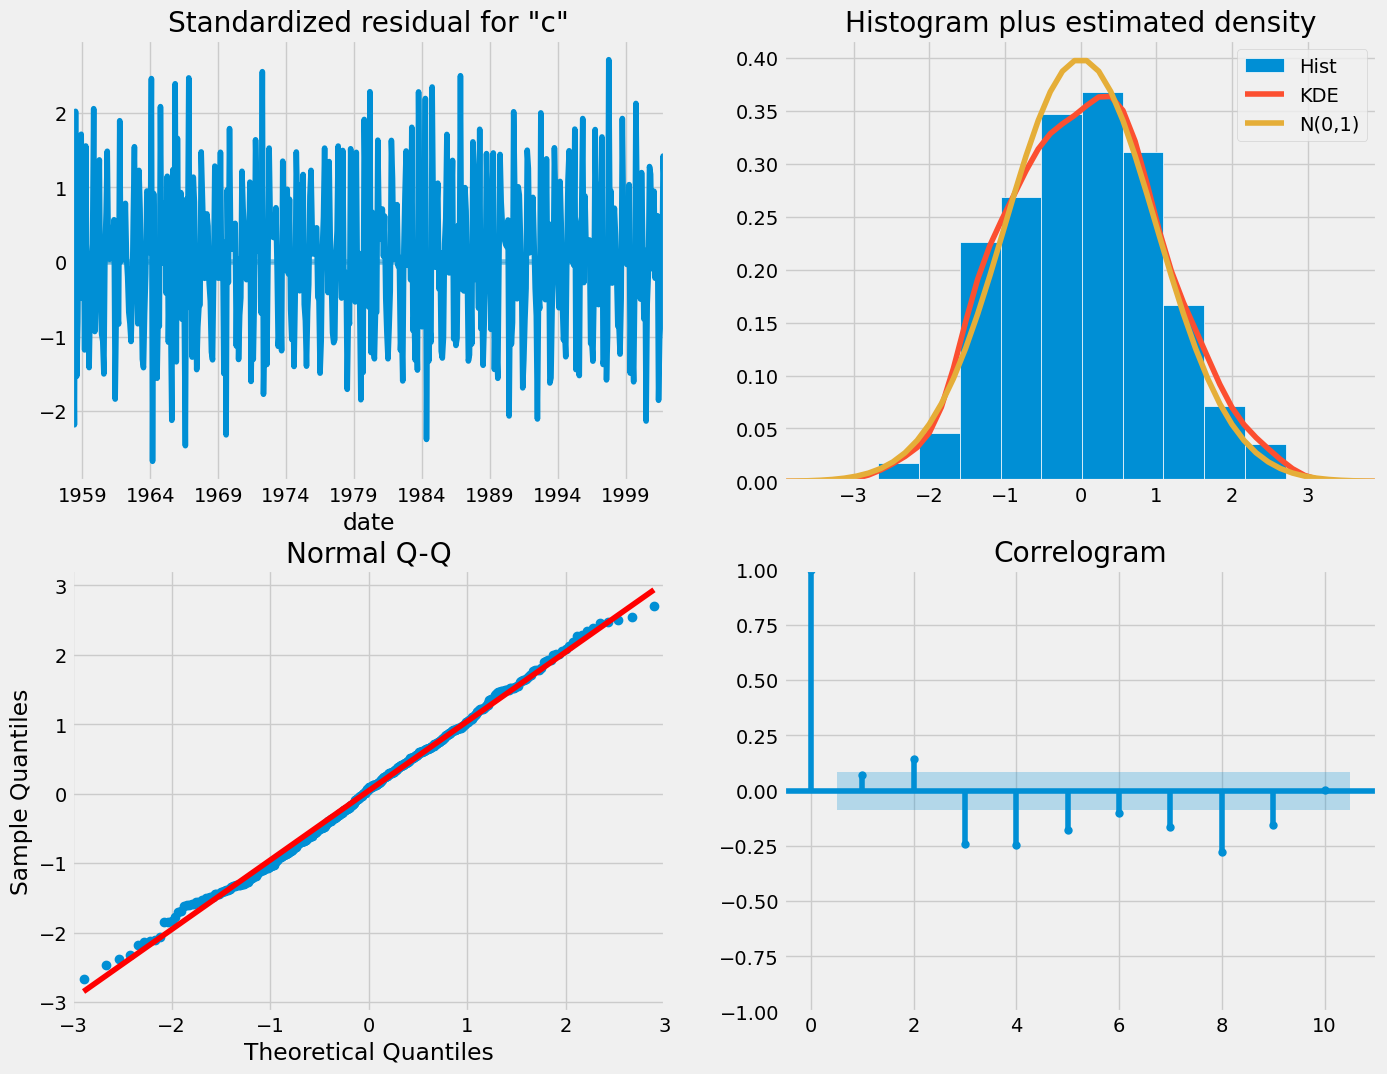

In [30]:
sarimax = sm.tsa.statespace.SARIMAX(monthly,order=(1, 1, 1),)

TSresults = sarimax.fit()

#print(TSresults.summary().tables[1])

# Histogram of residuals: To check if the residuals are normally distributed.
# Q-Q plot (Quantile-Quantile plot) of residuals: To compare the distribution of residuals with a normal distribution.
# ACF (Autocorrelation Function) plot of residuals: To check for autocorrelation in the residuals.
# Partial Autocorrelation Function (PACF) plot of residuals: To check for partial autocorrelation in the residuals.

TSresults.plot_diagnostics(figsize=(15, 12))
plt.show()

### Predict using this SARIMAX model, dynamic set to False

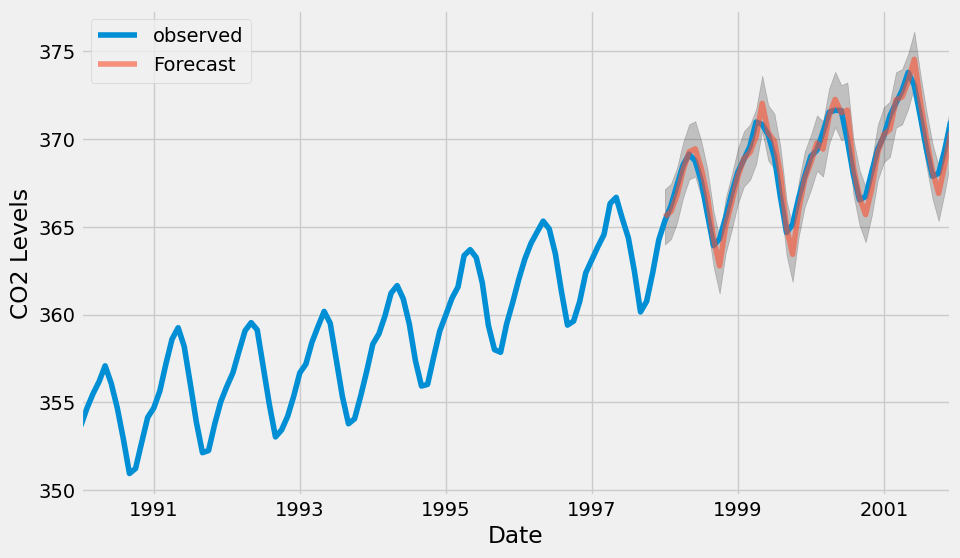

In [31]:
# Get predictions from the SARIMAX model
# Setting dynamic=False, it means that the model uses the entire history of the observed series (including the forecasted values) up to the point
# of each forecast to generate subsequent forecasts.
pred = TSresults.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)
# Obtain confidence intervals for the predictions
pred_ci = pred.conf_int()
#Returns the confidence interval of the fitted parameters.

plt.figure(figsize=(10, 6))
# Plot observed CO2 levels from the original time series
ax = monthly['1990':].plot(label='observed')

# Plot forecasted mean values from the SARIMAX model
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.6)

# Shade the area between the upper and lower bounds of the confidence interval
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()

In [32]:
pred_ci.head()

,lower co2,upper co2
date,,
1998-01-01,363.993241,367.143395
1998-02-01,364.302464,367.452618
1998-03-01,365.221551,368.371705
1998-04-01,366.662383,369.812537
1998-05-01,367.698431,370.848585


### Use MSE to evaluate our prediction

In [33]:
monthly_forecasted = pred.predicted_mean
monthly_truth = monthly['1998-01-01':]

# Compute the mean square error
mse = ((monthly_forecasted - monthly_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.57


### Predict using this SARIMAX model, dynamic set to True

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['full_results']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



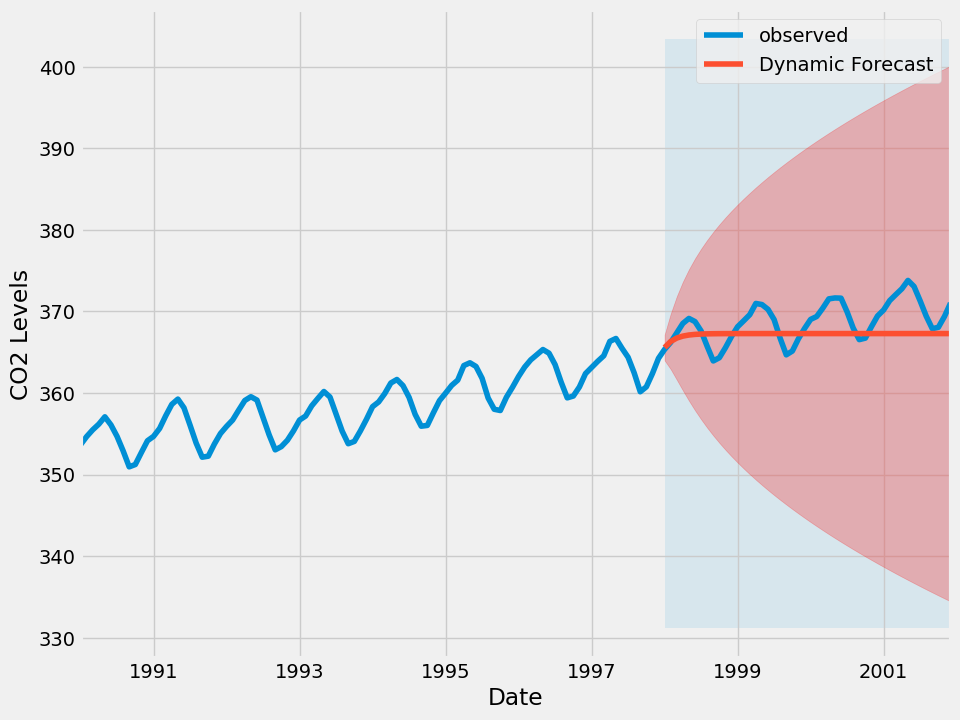

In [34]:
# Get predictions from the SARIMAX model
# Setting dynamic=True, the model only uses the observed values up to the point of each forecast to generate subsequent forecasts.
# In this case, the model does not use its own forecasts beyond the forecast period.
pred_dynamic = TSresults.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=True, full_results=True)
# Get confidence intervals for the dynamic predictions
pred_dynamic_ci = pred_dynamic.conf_int()

plt.figure(figsize=(10, 6))
# Plot observed CO2 levels from the original time series
ax = monthly['1990':].plot(label='observed', figsize=(10, 8))

# Plot forecasted mean values from the SARIMAX model
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,pred_dynamic_ci.iloc[:, 0],pred_dynamic_ci.iloc[:, 1], color='r', alpha=.25)

# Highlight the forecast period
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), monthly.index[-1],alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

In [35]:
monthly_forecasted = pred_dynamic.predicted_mean
monthly_truth = monthly['1998-01-01':]

# Compute the mean square error
mse = ((monthly_forecasted - monthly_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 7.81


# 2nd Part: MSFT stock price forecast

## Setup Google Drive Environment



In [36]:
#import pandas as pd
#import numpy as np

from tabulate import tabulate

link = 'https://drive.google.com/open?id=1wdf3FfKdR_xNh2rJeYWL4ye0_FUZ9WM7'


fluff, id = link.split('=')
file = drive.CreateFile({'id':id})
file.GetContentFile('MSFT_Stock.csv')
# Read the CSV file into a pandas DataFrame，parse the specified column as datetime objects，sets the specified column as the index of the DataFrame
microsoft  = pd.read_csv('MSFT_Stock.csv', index_col='Date', parse_dates=['Date'])
TS_Monthly_df   = pd.read_csv('MSFT_Stock.csv')
microsoft.head()

,Open,High,Low,Close,Volume
Date,,,,,
2015-04-01 16:00:00,40.60,40.76,40.31,40.72,36865322
2015-04-02 16:00:00,40.66,40.74,40.12,40.29,37487476
2015-04-06 16:00:00,40.34,41.78,40.18,41.55,39223692
2015-04-07 16:00:00,41.61,41.91,41.31,41.53,28809375
2015-04-08 16:00:00,41.48,41.69,41.04,41.42,24753438


In [37]:
import matplotlib.pyplot as plt
TS_df = microsoft

## Data Exploration

### Understand the raw dataset

In [38]:
TS_df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2015-04-01 16:00:00,40.60,40.76,40.31,40.72,36865322
2015-04-02 16:00:00,40.66,40.74,40.12,40.29,37487476
2015-04-06 16:00:00,40.34,41.78,40.18,41.55,39223692
2015-04-07 16:00:00,41.61,41.91,41.31,41.53,28809375
2015-04-08 16:00:00,41.48,41.69,41.04,41.42,24753438


In [39]:
TS_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1511 entries, 2015-04-01 16:00:00 to 2021-03-31 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1511 non-null   float64
 1   High    1511 non-null   float64
 2   Low     1511 non-null   float64
 3   Close   1511 non-null   float64
 4   Volume  1511 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 70.8 KB


In [40]:
TS_df.nunique()

Open      1409
High      1400
Low       1397
Close     1398
Volume    1511
dtype: int64

In [41]:
TS_df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

### EDA

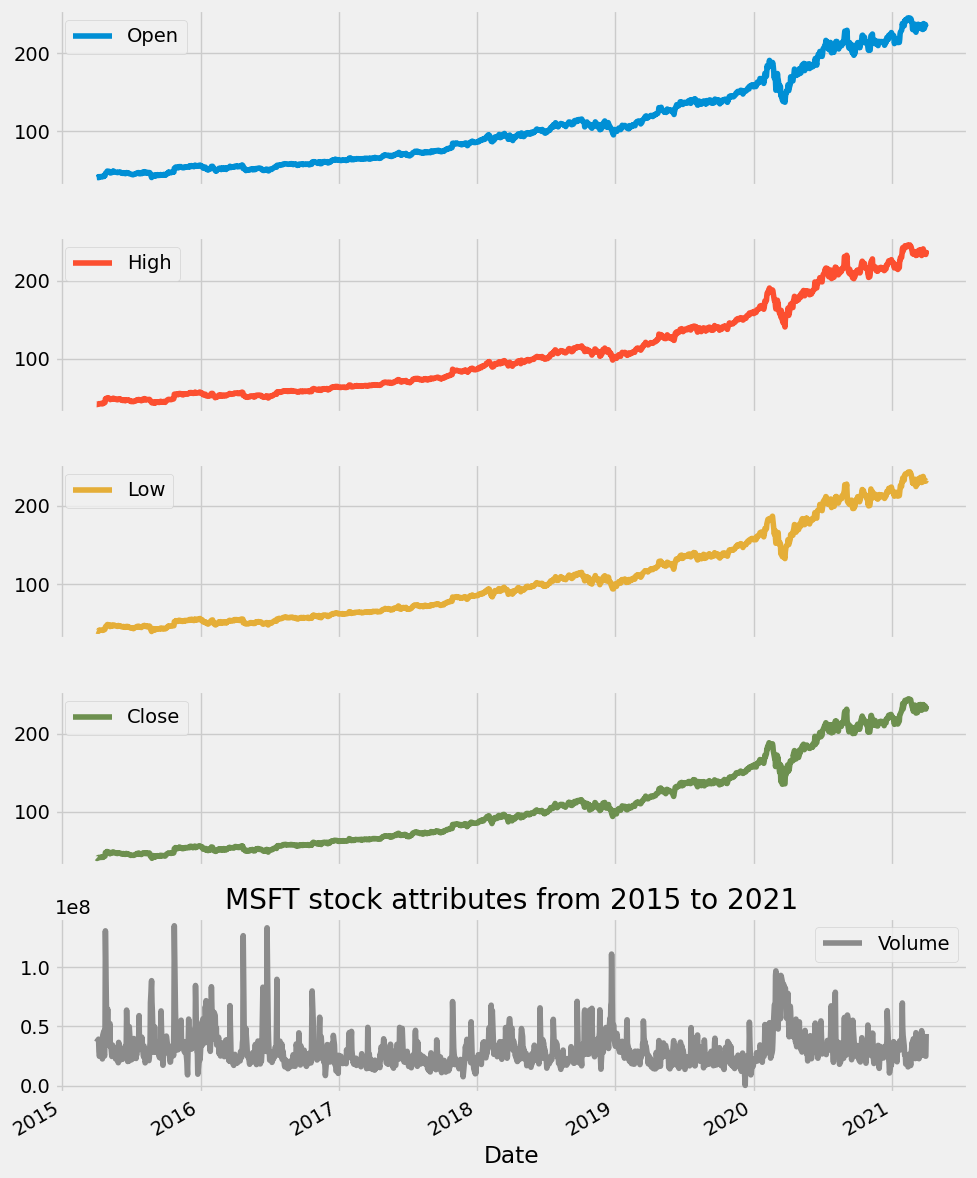

In [42]:
TS_df['2015':'2021'].plot(subplots=True, figsize=(10,12))
plt.title('MSFT stock attributes from 2015 to 2021')
plt.tight_layout()
# plt.savefig('stocks.png')

#### Check Daily Percentage Change

<Axes: xlabel='Date'>

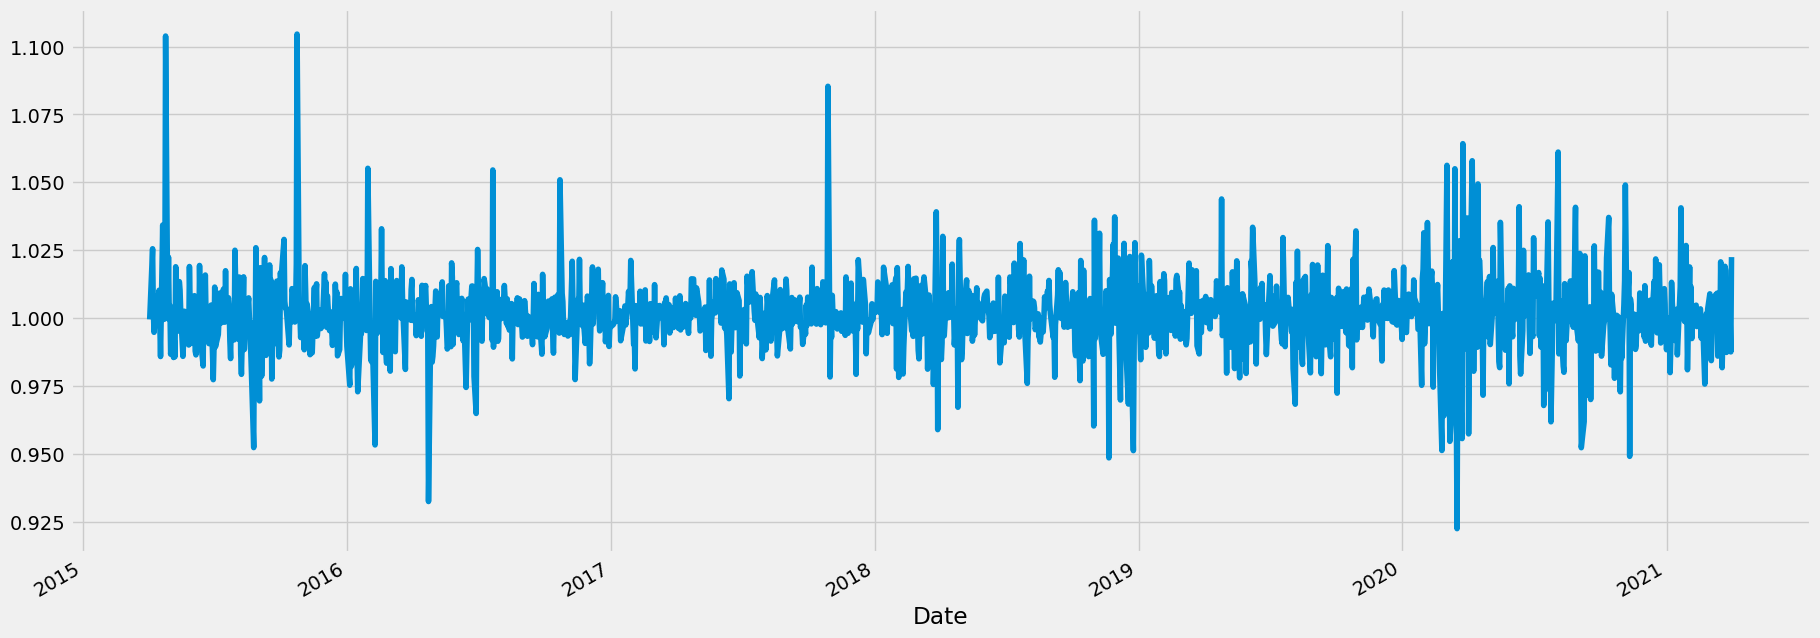

In [43]:
# Calculate the daily relative change in high prices
# TS_df.High.shift(): This shifts the 'High' column values down by one row, so each row now contains the high price of the previous day.
TS_df['Change'] = TS_df.High.div(TS_df.High.shift())
TS_df['Change'].plot(figsize=(20,8))

#### Check Daily Percentage Return

<Axes: xlabel='Date'>

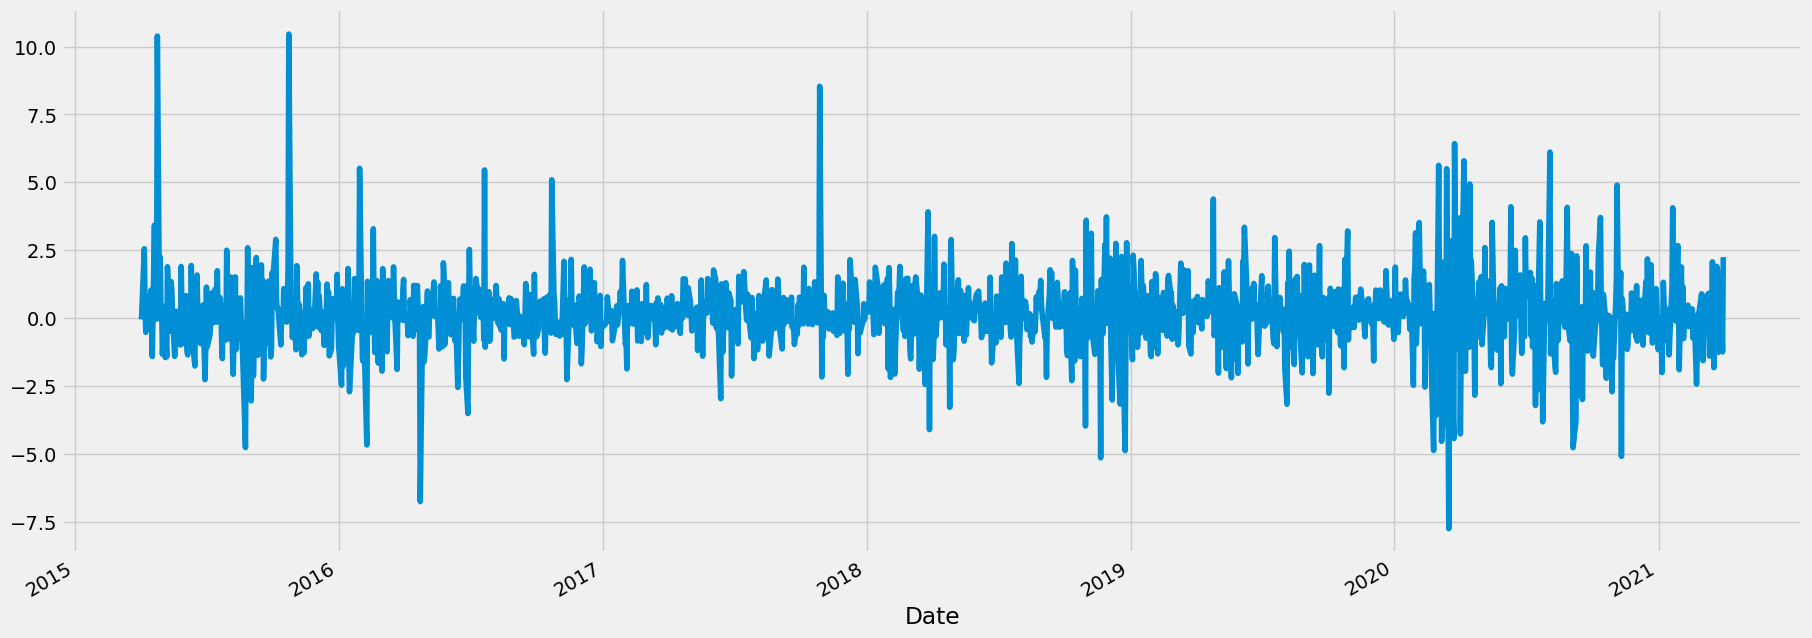

In [44]:
# Daily Percentage Return
# Substract the change value by 1 and multiply 100 to get a percentile value
TS_df['Return'] = TS_df.Change.sub(1).mul(100)
TS_df['Return'].plot(figsize=(20,8))

#### Check if there was any Trend in the high column

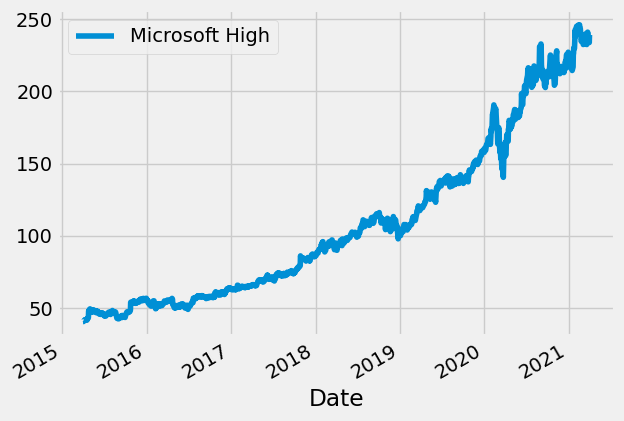

In [45]:
TS_df.High.plot()
plt.legend(['Microsoft High'])

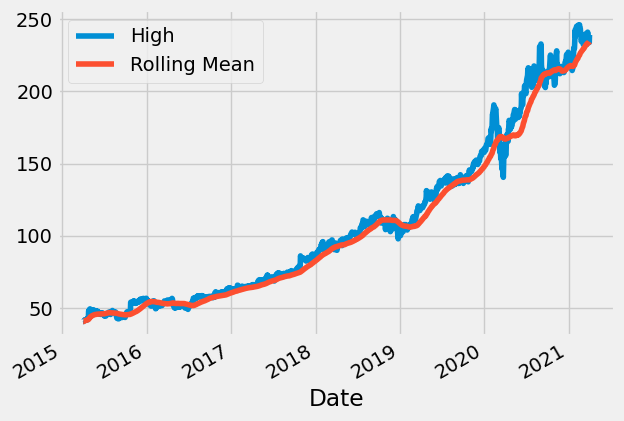

In [46]:
# Calculate the 90-day rolling mean of high prices
rolling_MSFT = TS_df.High.rolling('90D').mean()
TS_df.High.plot()
rolling_MSFT.plot()

plt.legend(['High','Rolling Mean'])

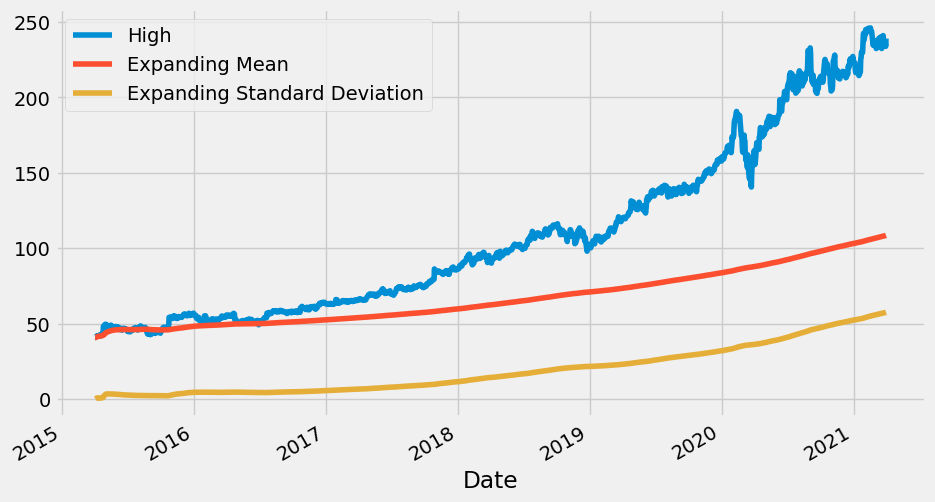

In [47]:
# Calculate the expanding mean of high prices
# expanding here is to create an expanding window over the 'High' column,
# starting from the first observation and including all previous data points up to each point.
microsoft_mean = TS_df.High.expanding().mean()
# Calculate the expanding standard deviation of high prices
microsoft_std = TS_df.High.expanding().std()
TS_df.High.plot(figsize=(10,6))
microsoft_mean.plot()
microsoft_std.plot()
plt.legend(['High','Expanding Mean','Expanding Standard Deviation'])

#### Check ACF and PACF plot

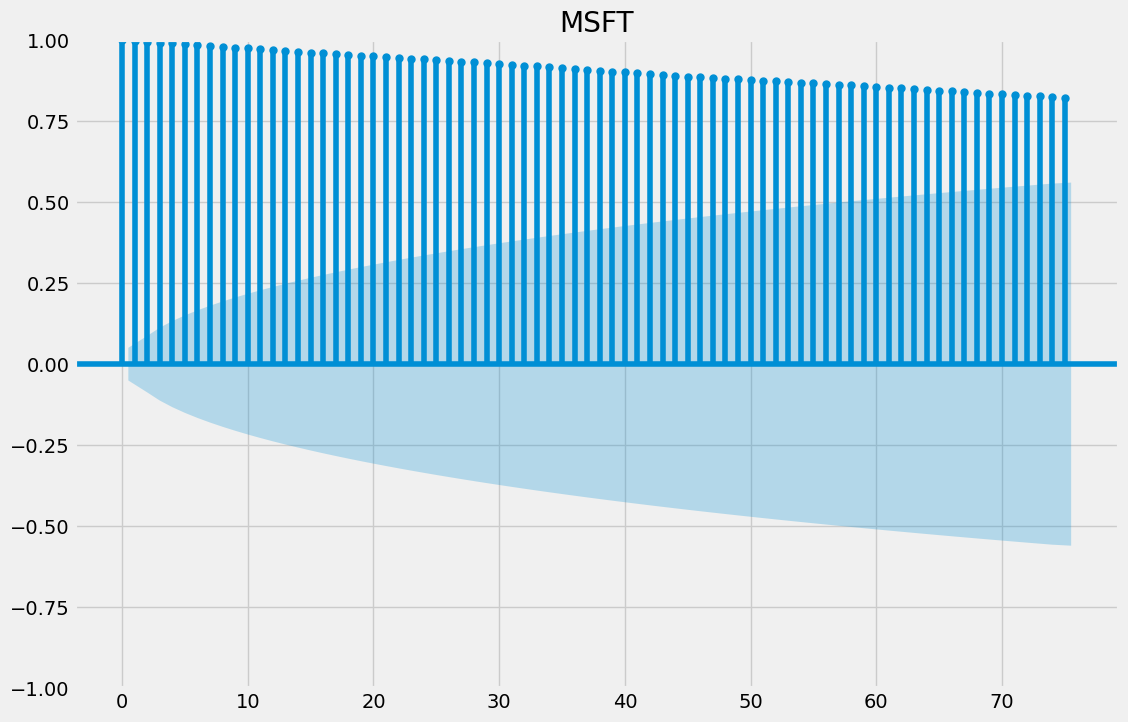

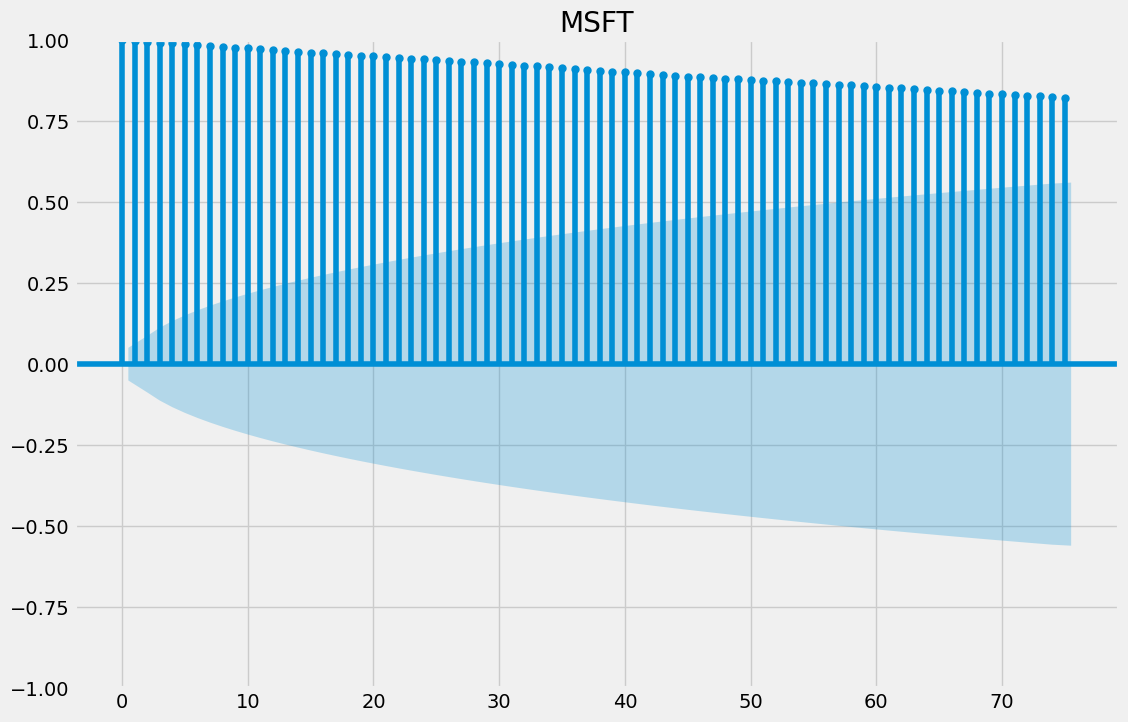

In [48]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(figsize=(12, 8))
plot_acf(TS_df["High"],lags=75,ax=ax,title="MSFT")

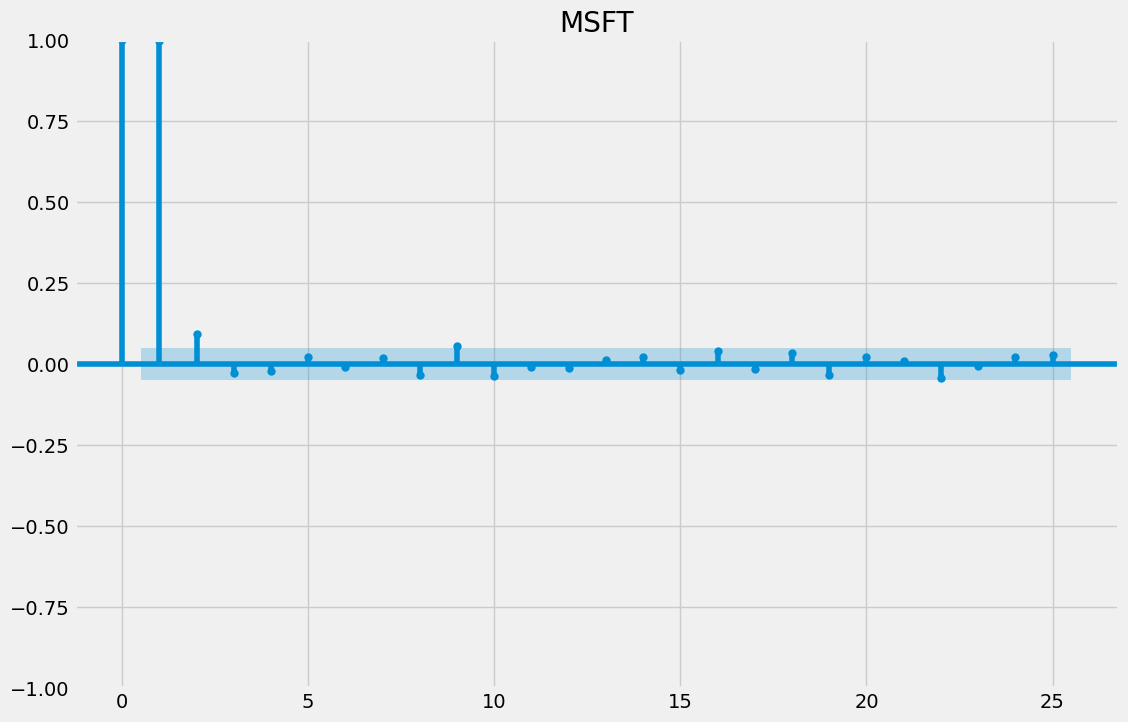

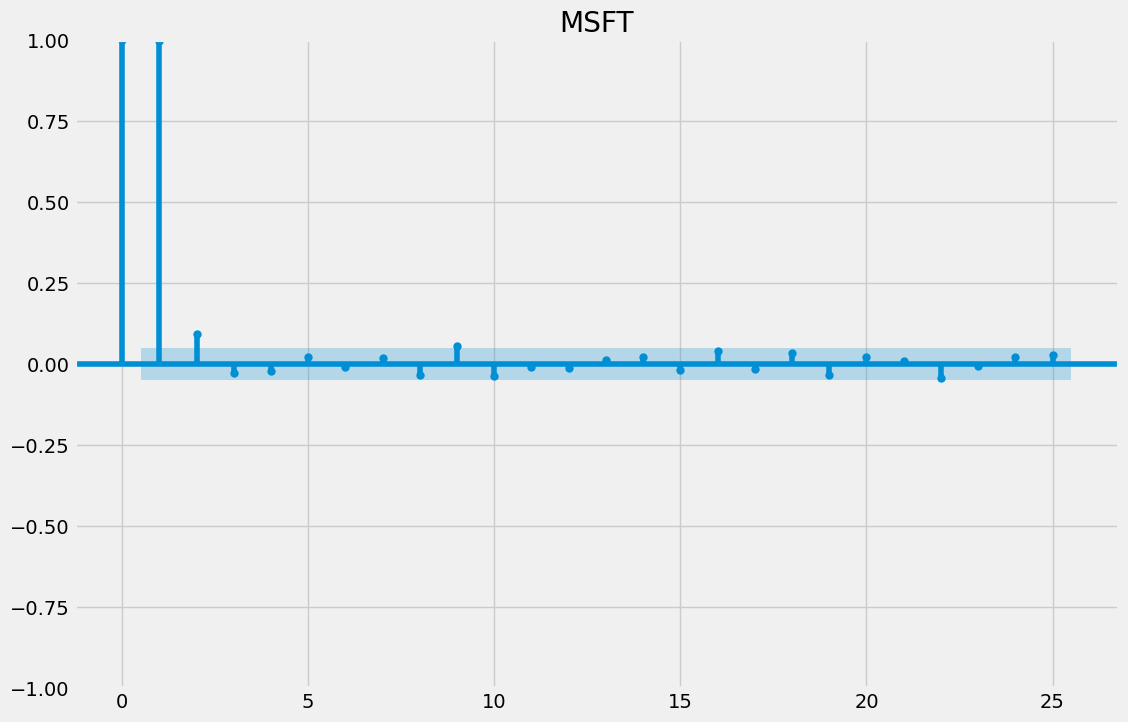

In [49]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_pacf(TS_df["Close"],lags=25,ax=ax,title="MSFT")

In [50]:
# Convert the 'Date' column to datetime format and create a new column 'dateN'
TS_Monthly_df['dateN']=pd.to_datetime(TS_Monthly_df['Date'])
# Set the 'dateN' column as the index of the DataFrame
TS_Monthly_df.set_index('dateN',inplace=True)
TS_Monthly_df.head()

,Date,Open,High,Low,Close,Volume
dateN,,,,,,
2015-04-01 16:00:00,4/1/2015 16:00:00,40.60,40.76,40.31,40.72,36865322
2015-04-02 16:00:00,4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476
2015-04-06 16:00:00,4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692
2015-04-07 16:00:00,4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375
2015-04-08 16:00:00,4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438


<Axes: xlabel='dateN'>

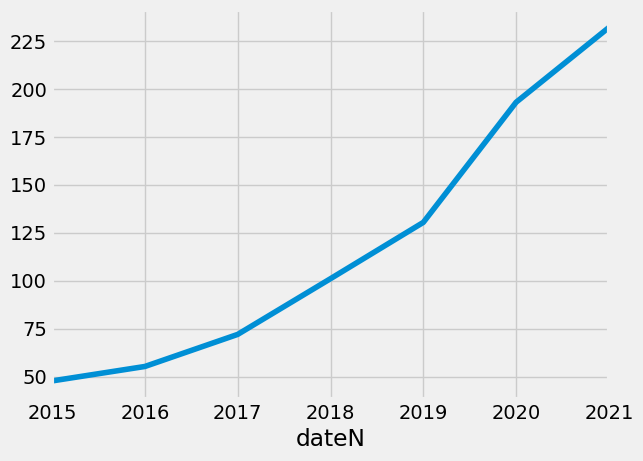

In [51]:
TS_Monthly_df['Close'].resample('Y').mean().plot()

In [52]:
TS_Monthly_df.describe()

,Open,High,Low,Close,Volume
count,1511.000000,1511.000000,1511.000000,1511.000000,1.511000e+03
mean,107.385976,108.437472,106.294533,107.422091,3.019863e+07
std,56.691333,57.382276,55.977155,56.702299,1.425266e+07
min,40.340000,40.740000,39.720000,40.290000,1.016120e+05
25%,57.860000,58.060000,57.420000,57.855000,2.136213e+07
50%,93.990000,95.100000,92.920000,93.860000,2.662962e+07
75%,139.440000,140.325000,137.825000,138.965000,3.431962e+07
max,245.030000,246.130000,242.920000,244.990000,1.352271e+08


### Data cleaning and feature analysis

#### Data description

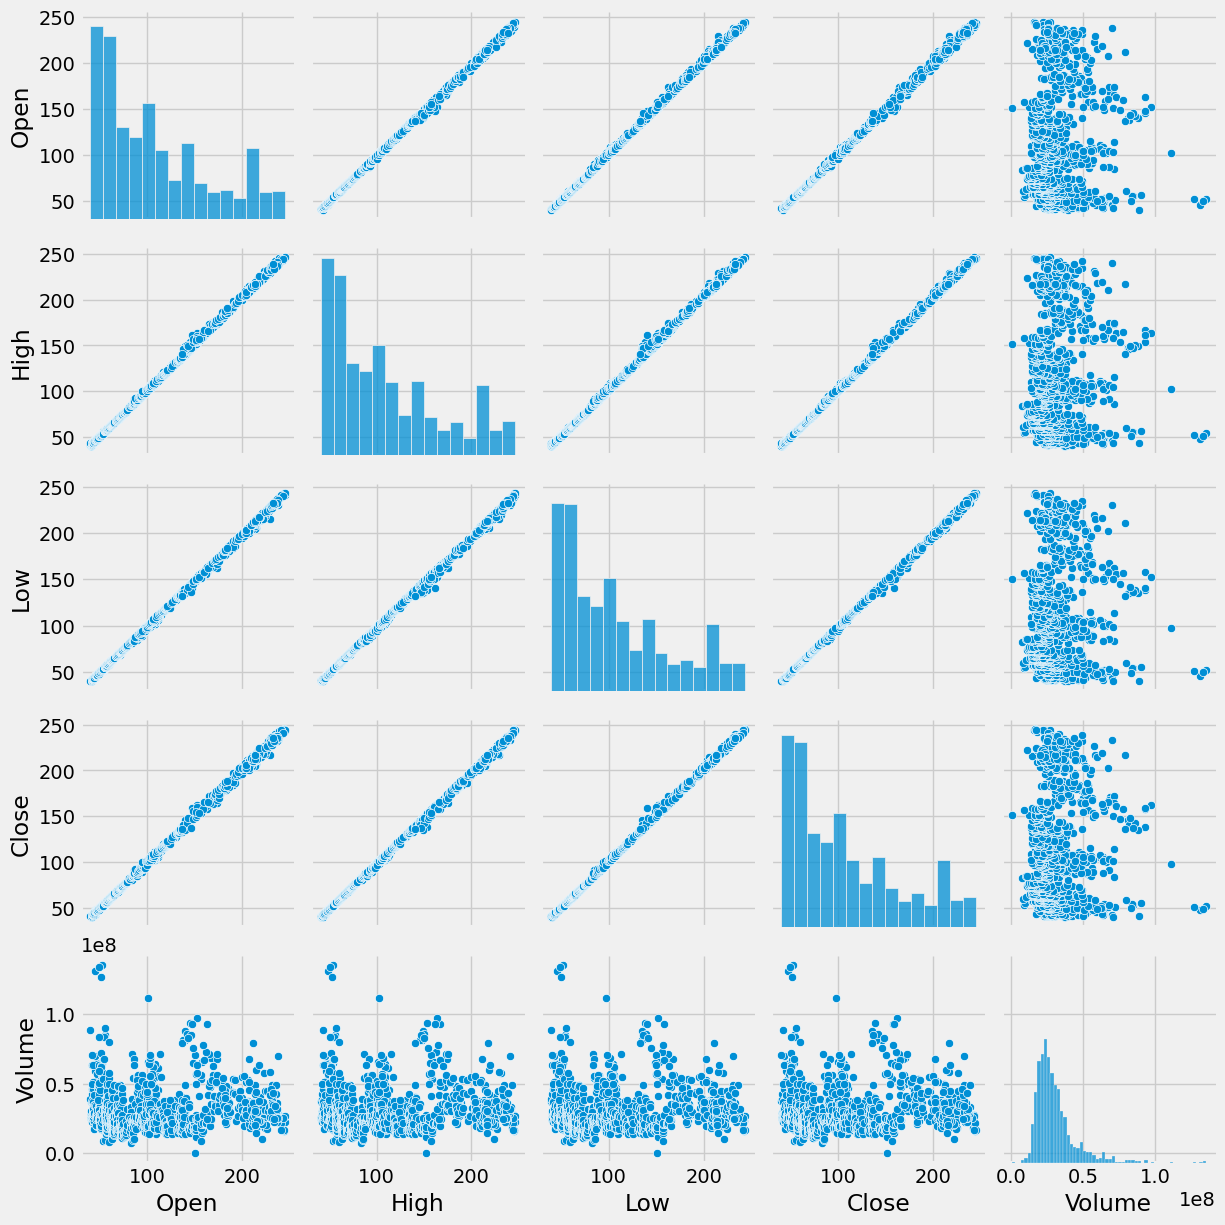

In [53]:
import seaborn as sns
sns.pairplot(data=TS_Monthly_df)

#### Perform seasonal decomposition on the close column

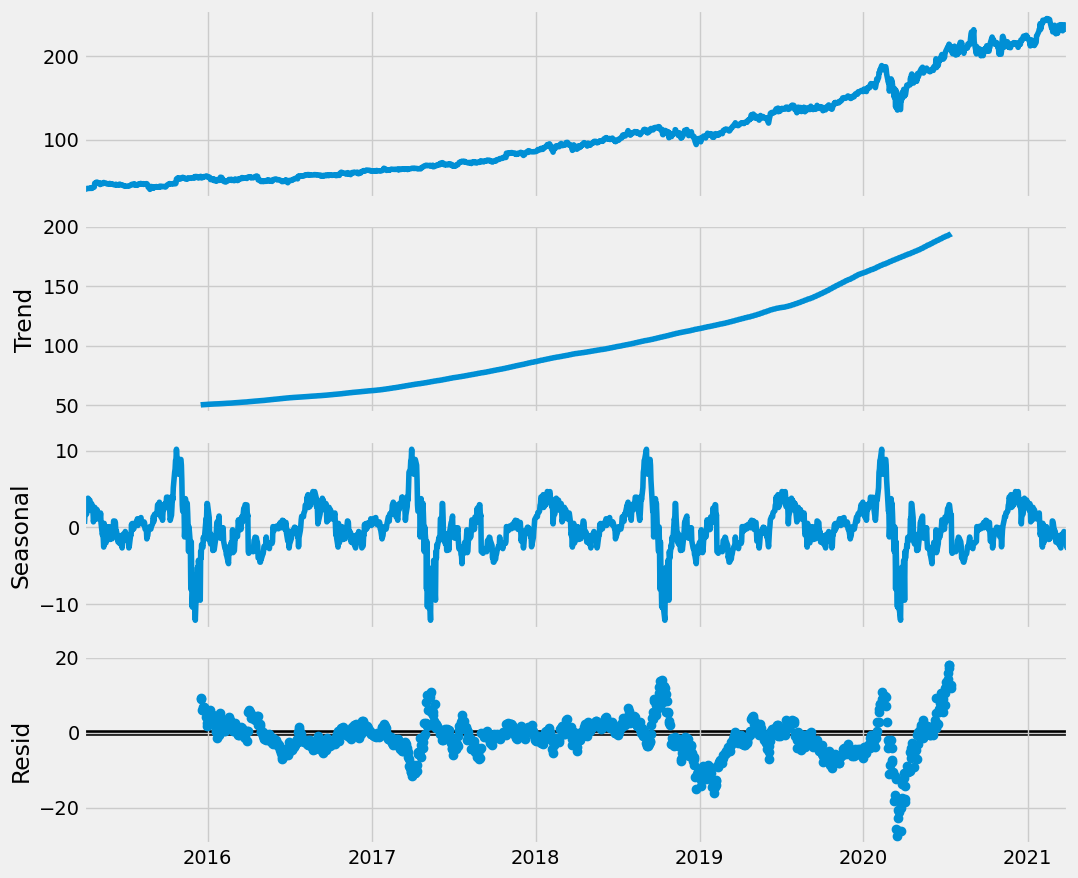

In [54]:
rcParams['figure.figsize'] = 11, 9
# plt.figure(figsize=(11, 9))
# Perform seasonal decomposition with the specified frequency (annually)
pred_df_sim1_new = sm.tsa.seasonal_decompose(TS_Monthly_df[['Close']],model='additive',period=360)
pred_df_sim2_full = TS_Monthly_df[['Close']]
figure = pred_df_sim1_new.plot()
plt.show()

In [55]:
# Check for null values in each component of the decomposition result
null_observed = pred_df_sim1_new.observed.isnull().any()
null_trend = pred_df_sim1_new.trend.isnull().any()
null_seasonal = pred_df_sim1_new.seasonal.isnull().any()
null_residual = pred_df_sim1_new.resid.isnull().any()

# Print the results
print("Null values in observed component:", null_observed)
print("Null values in trend component:", null_trend)
print("Null values in seasonal component:", null_seasonal)
print("Null values in residual component:", null_residual)

Null values in observed component: False
Null values in trend component: True
Null values in seasonal component: False
Null values in residual component: True


In [56]:
# Remove null values
sim1 = pred_df_sim1_new.resid.dropna()
sim2 = pred_df_sim2_full.dropna()

### Model part

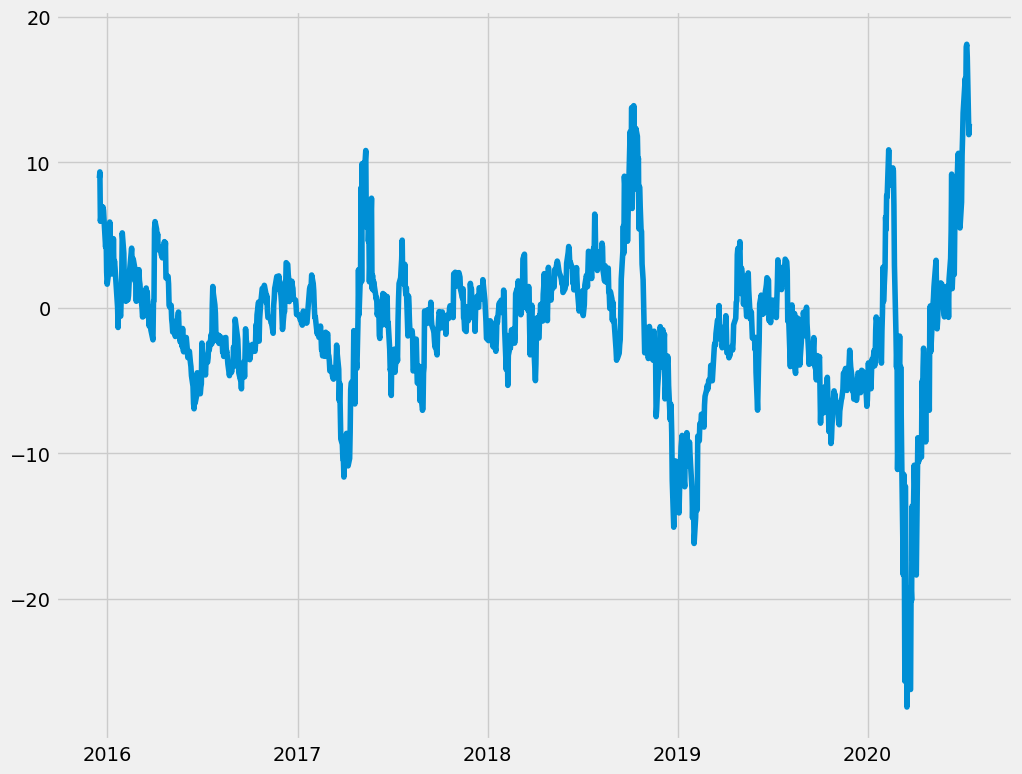

In [57]:
plt.plot(sim1)

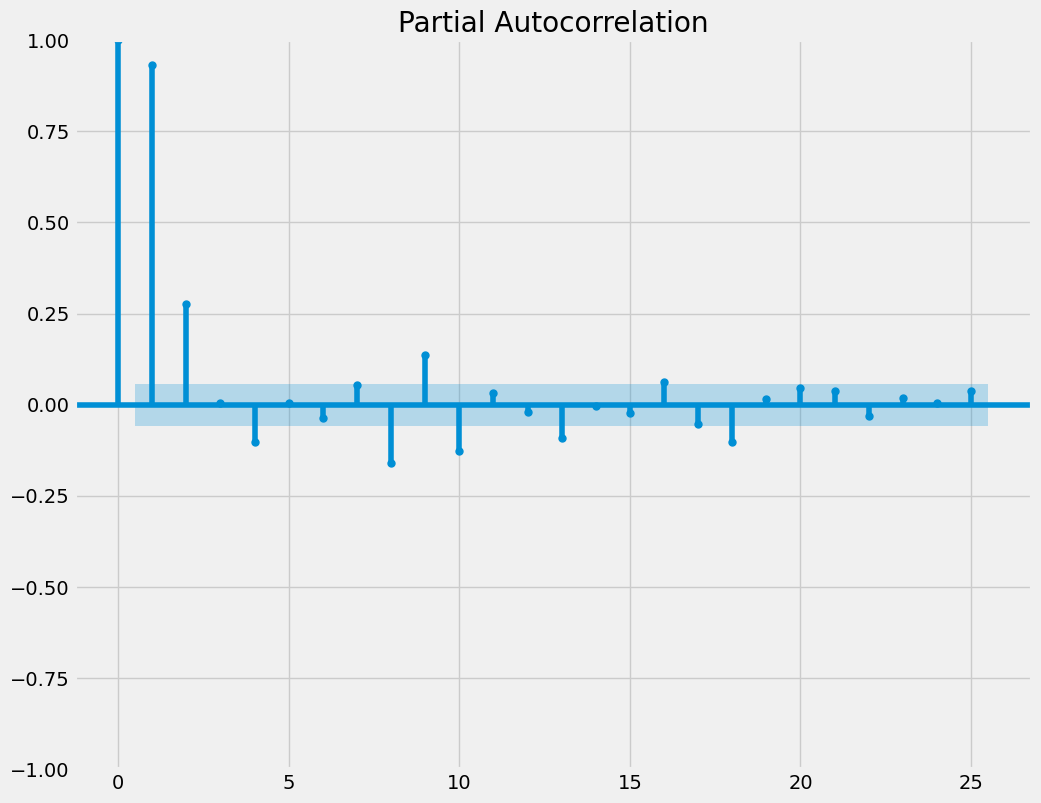

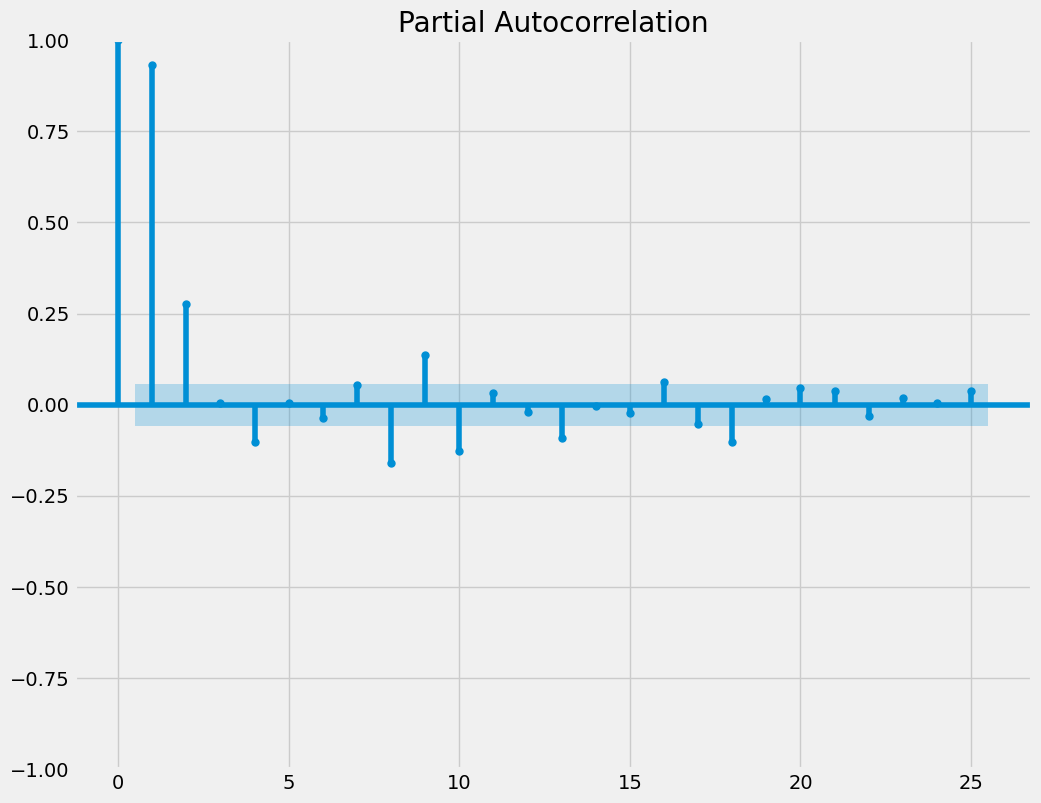

In [58]:
plot_pacf(sim1, lags=25)

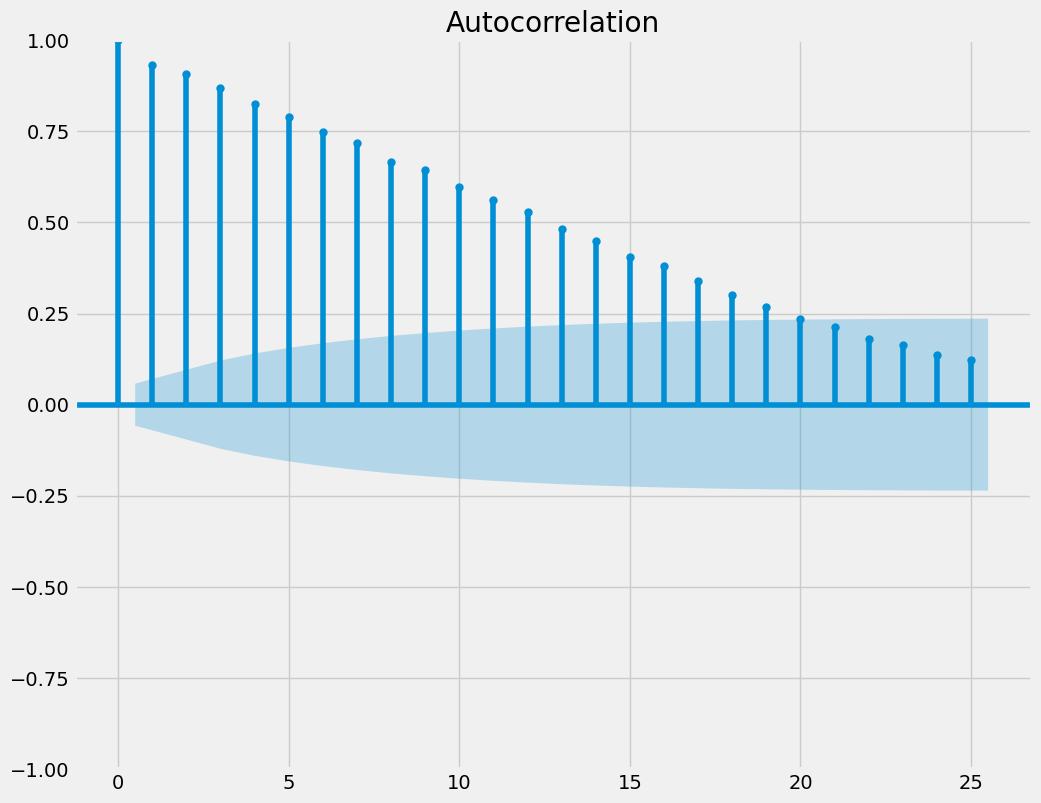

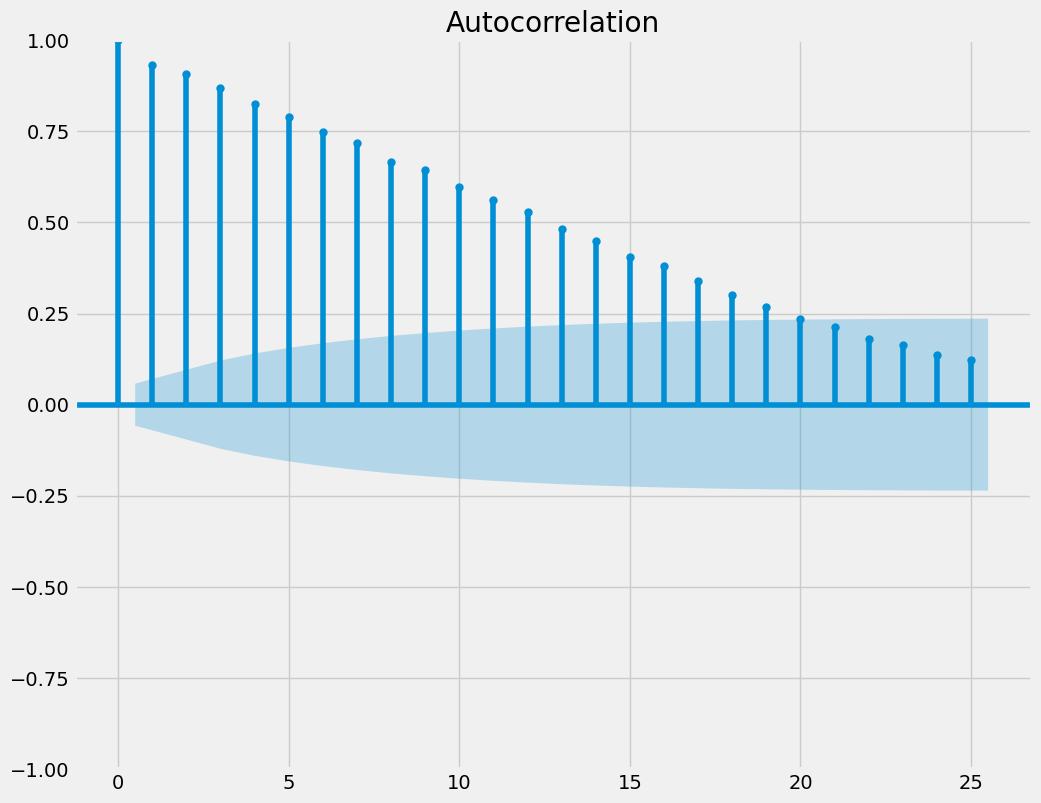

In [59]:
plot_acf(sim1, lags=25)

#### SARIMAX model with p,d,q = 2,3,2

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



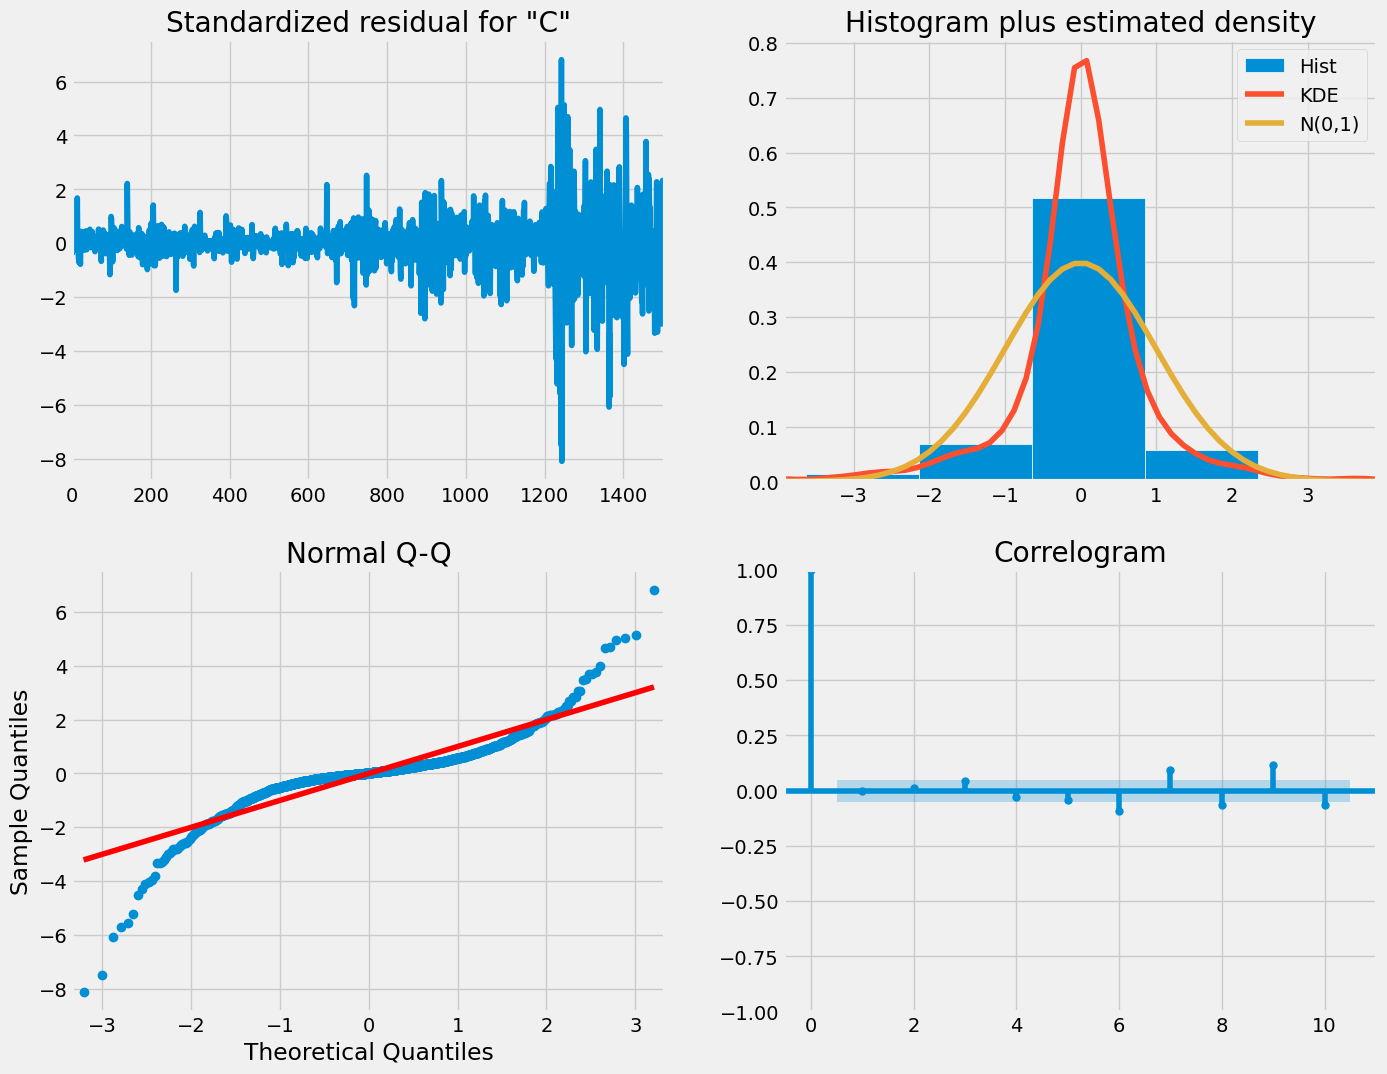

In [60]:
# Get predictions from the SARIMAX model
mod = sm.tsa.statespace.SARIMAX(sim2,order=(2, 3, 2),)

MSFTresults = mod.fit()

#print(TSresults.summary().tables[1])

MSFTresults.plot_diagnostics(figsize=(15, 12))
plt.show()

In [61]:
# Setting dynamic=True, the model only uses the observed values up to the point of each forecast to generate subsequent forecasts.
# In this case, the model does not use its own forecasts beyond the forecast period.
# Start = 1400, indicating the prediction starts from the 1400th obnservations within the dataset
pred = MSFTresults.get_prediction(start=1400, dynamic=True)

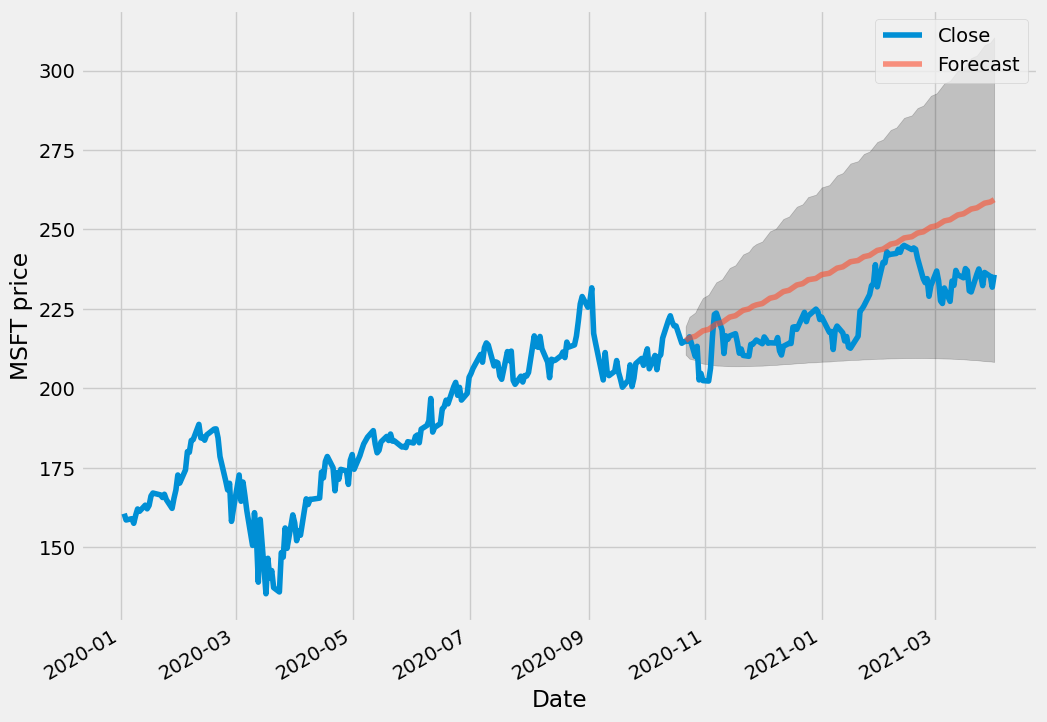

In [62]:
pred_ci = pred.conf_int()
#Returns the confidence interval of the fitted parameters.

ax = sim2['2020':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.6)

ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('MSFT price')
plt.legend()

plt.show()

#### Grid search below to find the optimal combination of parameters

In [63]:
import itertools
from tqdm import tqdm

In [64]:
# Define the range of parameters
p = d = q = range(0, 3)
P = D = Q = range(0, 3)
s = [12]  # For monthly data with a yearly seasonal cycle

# Generate all different combinations of p, d, q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, d, q triplets
seasonal_pdq = [(x[0], x[1], x[2], s[0]) for x in list(itertools.product(P, D, Q))]

In [65]:
best_aic = float("inf")
best_params = None

for param in tqdm(pdq):
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(sim2,order=param,
                             seasonal_order=param_seasonal,
                             enforce_stationarity=False,
                             enforce_invertibility=False)
            results = mod.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = (param, param_seasonal)
        except:
            continue

print('Best SARIMAX model parameters:')
print('ARIMA order:', best_params[0])
print('Seasonal order:', best_params[1])

Streaming output truncated to the last 5000 lines.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency in

Best SARIMAX model parameters:
ARIMA order: (2, 2, 2)
Seasonal order: (0, 0, 2, 12)


In [66]:
print('Best SARIMAX model parameters:')
print('ARIMA order:', best_params[0])
print('Seasonal order:', best_params[1])

Best SARIMAX model parameters:
ARIMA order: (2, 2, 2)
Seasonal order: (0, 0, 2, 12)


#### Check the prediction from the optimal model

In [ ]:
# Get predictions from the SARIMAX model
mod = sm.tsa.statespace.SARIMAX(sim2,order=(2, 3, 2),)

MSFTresults = mod.fit()

#print(TSresults.summary().tables[1])

MSFTresults.plot_diagnostics(figsize=(15, 12))
plt.show()